**The main aim of this notebook is overview of Electra base with NLP Disaster Tweets**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv


Just to submit perfect score :)

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU 확인", torch.cuda.get_device_name(0))
else:
    print("GPU 없음")
    device = torch.device('cpu')

GPU 확인 Tesla P100-PCIE-16GB


In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
import re


In [6]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]', '', text)
    
    text = text.replace(r'&amp;?', r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    
    # 해시태그 삭제
    text = re.sub(r'#', '', text)
    
    # @ 삭제
    text = re.sub(r"(?:\@)\w+", "", text)
    
    # ascii 문자 삭제
    text = text.encode('ascii', errors = 'ignore').decode()
    
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text = "".join(text.split())
    return text

In [7]:
df_train['text'] = df_train['text'].apply(preprocess)
df_test['test'] = df_test['text'].apply(preprocess)

df_train = df_train[df_train['text']!='']

In [8]:
df_train[['text', 'target']]

,text,target
0,ourdeedsarethereasonofthisearthquakemayallahfo...,1
1,forestfirenearlarongesaskcanada,1
2,allresidentsaskedtoshelterinplacearebeingnotif...,1
3,13000peoplereceivewildfiresevacuationordersinc...,1
4,justgotsentthisphotofromrubyalaskaassmokefromw...,1
...,...,...
7608,twogiantcranesholdingabridgecollapseintonearby...,1
7609,theoutofcontrolwildfiresincaliforniaeveninthen...,1
7610,m194[0104utc]?5kmsofvolcanohawaiihttptcozdtoyd...,1
7611,policeinvestigatingafteranebikecollidedwithaca...,1


In [9]:
df_train = df_train[['text', 'target']]

In [10]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
texts= df_train.text.values
labels = df_train.target.values

In [12]:
texts

array(['ourdeedsarethereasonofthisearthquakemayallahforgiveusall',
       'forestfirenearlarongesaskcanada',
       'allresidentsaskedtoshelterinplacearebeingnotifiedbyofficersnootherevacuationorshelterinplaceordersareexpected',
       ..., 'm194[0104utc]?5kmsofvolcanohawaiihttptcozdtoyd8ebj',
       'policeinvestigatingafteranebikecollidedwithacarinlittleportugalebikeridersufferedseriousnonlifethreateninginjuries',
       'thelatestmorehomesrazedbynortherncaliforniawildfireabcnewshttptcoymy4rskq3d'],
      dtype=object)

In [13]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [14]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
import matplotlib.pyplot as plt


In [16]:
texts

array(['ourdeedsarethereasonofthisearthquakemayallahforgiveusall',
       'forestfirenearlarongesaskcanada',
       'allresidentsaskedtoshelterinplacearebeingnotifiedbyofficersnootherevacuationorshelterinplaceordersareexpected',
       ..., 'm194[0104utc]?5kmsofvolcanohawaiihttptcozdtoyd8ebj',
       'policeinvestigatingafteranebikecollidedwithacarinlittleportugalebikeridersufferedseriousnonlifethreateninginjuries',
       'thelatestmorehomesrazedbynortherncaliforniawildfireabcnewshttptcoymy4rskq3d'],
      dtype=object)

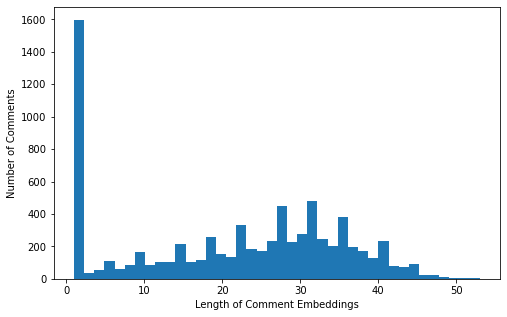

In [17]:
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(texts, tokenizer)

In [18]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)


In [19]:
len(indices['input_ids'])

7613

In [20]:
input_ids = indices['input_ids']

In [21]:
attention_masks=indices["attention_mask"]

In [22]:
print(indices["attention_mask"][0])
print(len(indices['attention_mask']))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7613


In [23]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(input_ids, 
                                                      labels,
                                                      random_state=42, 
                                                      test_size=0.2)


In [24]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       labels,
                                                       random_state=42, 
                                                       test_size=0.2)

In [25]:
train_inputs = torch.tensor(x_train)
validation_inputs = torch.tensor(x_valid)

train_labels = torch.tensor(y_train, dtype=torch.long)
validation_labels = torch.tensor(y_valid, dtype =torch.long)

train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks= torch.tensor(validation_masks, dtype = torch.long)

In [26]:
from torch.utils.data import TensorDataset,\
                             DataLoader,\
                             RandomSampler,\
                             SequentialSampler

In [27]:
# batch 사이즈
batch_size  = 32

### train set

In [28]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_data

In [29]:
train_sampler = RandomSampler(train_data)
train_sampler

In [30]:
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
train_dataloader

In [31]:
# validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [32]:
# 옵티마이져
optimizer = AdamW(model.parameters(), lr = 6e-6, eps=1e-8)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    lr: 6e-06
    weight_decay: 0.0
)

In [33]:
from transformers import get_linear_schedule_with_warmup

In [34]:
epochs = 10
total_steps = len(train_dataloader)*epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [35]:
def flat_accuarcy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat ==labels_flat) / len(labels_flat)

In [36]:
import time
import datetime
import random

In [37]:
def format_time(t):
    t = int(round(t))
    return str(datetime.timedelta(seconds =t))

In [38]:
loss_values = []

In [39]:
for epoch_ in range(0, epochs):
    print(" ")
    print("=========== Epoch {:} / {:} ========".format(epoch_+1, epochs))
    print("training......")
    
    time_ = time.time()
    
    # loss 초기화
    total_loss = 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step ==0:
            elapsed= format_time(time.time() -time_)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        batch_inputs_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        model.zero_grad()
        outputs = model(batch_inputs_ids,
                       token_type_ids = None,
                       attention_mask = batch_input_mask,
                       labels=batch_labels)
        loss = outputs[0]
        total_loss +=loss.item()
        loss.backward()
        
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    
    print("")    
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - time_)))
      
print("")
print("Training complete!")

 
=========== Epoch 1 / 10 ========
training......
  Batch    50  of    191.    Elapsed: 0:00:11.
  Batch   100  of    191.    Elapsed: 0:00:21.
  Batch   150  of    191.    Elapsed: 0:00:31.

  Average training loss: 0.66
  Training epoch took: 0:00:40
 
=========== Epoch 2 / 10 ========
training......
  Batch    50  of    191.    Elapsed: 0:00:10.
  Batch   100  of    191.    Elapsed: 0:00:20.
  Batch   150  of    191.    Elapsed: 0:00:31.

  Average training loss: 0.62
  Training epoch took: 0:00:39
 
=========== Epoch 3 / 10 ========
training......
  Batch    50  of    191.    Elapsed: 0:00:10.
  Batch   100  of    191.    Elapsed: 0:00:20.
  Batch   150  of    191.    Elapsed: 0:00:31.

  Average training loss: 0.58
  Training epoch took: 0:00:39
 
=========== Epoch 4 / 10 ========
training......
  Batch    50  of    191.    Elapsed: 0:00:10.
  Batch   100  of    191.    Elapsed: 0:00:20.
  Batch   150  of    191.    Elapsed: 0:00:31.

  Average training loss: 0.55
  Training epoc

# validation

In [40]:
print('검증...')

# 시간
time_ = time.time()

# 검증
model.eval()

preds = []
true = []

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    
    # 정확도
    tmp_eval_accuracy = flat_accuarcy(logits, label_ids)
    
    # 전체 acc 축적
    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - time_)))

검증...
  Accuracy: 0.71
  Validation took: 0:00:03


# submission

In [41]:
comments1= df_test.text.values

In [42]:
indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)

In [43]:
batch_size=  32

In [44]:
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

In [45]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

predictions = []

for batch in prediction_dataloader1:
    
    batch = tuple(t.to(device) for t in batch)

    b_input_ids1, b_input_mask1 = batch
  
    with torch.no_grad():
        outputs1 = model(b_input_ids1, token_type_ids=None, 
                        attention_mask=b_input_mask1)

        logits1 = outputs1[0]

    logits1 = logits1.detach().cpu().numpy()
    predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [46]:
flat_predictions

array([1, 0, 1, ..., 1, 0, 1])

In [47]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':flat_predictions})

In [48]:
submit

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [49]:
submit.to_csv('submission.csv',index=False)